# HW 2: Flow Models
**Meng Linghui**  

mengreinhold@163.com

In [2]:
import numpy as np
def sample_data():
  count = 6000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [3]:
X, y = sample_data()

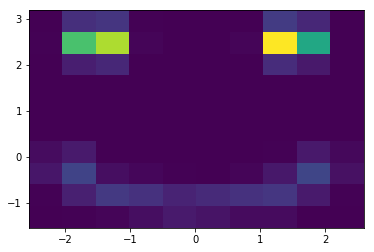

In [5]:
import matplotlib.pyplot as plt
plt.hist2d(X[:,0], X[:,1])
plt.show()

### Different parameters

In [6]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F

In [7]:
class flow(nn.Module):
    
    def __init__(self, k=6):   # 6维混合高斯
        super(flow, self).__init__()
        self.k = k
        
        # layers
        self.layers = nn.Sequential(nn.Linear(1,100), nn.Tanh())
        self.network = nn.Sequential(*self.layers)
        self.pi = nn.Linear(100, self.k)
        self.mu = nn.Linear(100, self.k)
        self.sigma = nn.Linear(100, self.k)
        
    def forward(self, x):
        x = self.network(x)
        pi = F.softmax(self.pi(x), dim=-1).view(-1, self.k)
        mu = self.mu(x).view(-1, self.k)
        sigma = torch.exp(self.sigma(x)).view(-1, self.k)
        return pi, mu, sigma

In [12]:
class mycdf(nn.Module):
    
    def __init__(self, k=6):
        super(mycdf, self).__init__()
        self.k = k
        self.batch = 0
        self.pi = nn.Parameter(torch.randn(self.k, requires_grad=True))
        self.mu = nn.Parameter(torch.randn(self.k, requires_grad=True))
        self.sigma = nn.Parameter(torch.randn(self.k, requires_grad=True))
        
        self.fx2x1 = flow(self.k)
        
    def x_split(self, x):
        x1, x2 = x[:,0], x[:,1]
        self.batch = x1.shape[0]
        
        x1 = x1.reshape(-1, 1)
        x2 = x2.reshape(-1, 1)
        return x1, x2
    
    def pi_mu_sigma(self, x):
        x1, x2 = self.x_split(x)
        
        pi1, mu1, sigma1 = F.softmax(self.pi.repeat(self.batch,1)),self.mu.repeat(self.batch,1),torch.exp(self.sigma.repeat(self.batch,1))
        pi2, mu2, sigma2 = self.fx2x1.forward(x1)
        return (pi1, mu1, sigma1, pi2, mu2, sigma2)
    
    def f(self, x):
        
        pi1, mu1, sigma1, pi2, mu2, sigma2= self.pi_mu_sigma(x)
        
        z1 = torch.zeros(self.batch, 1)
        z2 = torch.zeros(self.batch, 1)
        
        x1, x2 = self.x_split(x)
        
        for i in range(self.k):
            z1 += pi1[:, i:i+1]*(Normal(mu1[:,i:i+1].float(), sigma1[:,i:i+1]).float()).cdf(x1)
            z2 += pi2[:,i:i+1]*(Normal(mu2[:,i:i+1].float(), sigma2[:,i:i+1]).float()).cdf(x2)
        
        return z1, a2
    
    def probs(self, x):
        
        pi1, mu1, sigma1, pi2, mu2, sigma2= self.pi_mu_sigma(x)
        
        prob_x1 = torch.zeros(self.batch, 1)
        prob_x2 = torch.zeros(self.batch, 1)
        
        x1, x2 = self.x_split(x)
        for i in range(self.k):
            prob_x1 += pi1[:,i:i+1]*(Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).log_prob(x1).exp())
            prob_x2 += pi2[:,i:i+1]*(Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).log_prob(x2).exp())
        
        return prob_x1*prob_x2
    
    def loss(self, x):
        return torch.mean(-torch.log(self.probs(x)))
        

In [13]:
mycdf = mycdf(12)

In [15]:
mycdf.loss(torch.Tensor(X[0:2]))

C:\Users\Reinhold\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(5.6759, grad_fn=<MeanBackward0>)

In [16]:
print(mycdf)
optimizer = torch.optim.Adam(mycdf.parameters(), lr=1e-3)
for param in mycdf.parameters():
    print(type(param.data), param.size())

mycdf(
  (fx2x1): flow(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
    )
    (network): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
    )
    (pi): Linear(in_features=100, out_features=12, bias=True)
    (mu): Linear(in_features=100, out_features=12, bias=True)
    (sigma): Linear(in_features=100, out_features=12, bias=True)
  )
)
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([100, 1])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([12, 100])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12, 100])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12, 100])
<class 'torch.Tensor'> torch.Size([12])


In [17]:
class Dataset:
    
    def __init__(self, X, y):
        self.images = X
        self.labels = y
        
    def __len__(self):
        
        return len(self.images)
    
    def __getitem__(self, idx):
        
        img = self.images[idx]
        label = self.labels[idx]
        
        return img, label
    

In [20]:
ds = Dataset(torch.FloatTensor(X[:5000]),torch.FloatTensor(y[:5000]))
ds2 = Dataset(torch.FloatTensor(X[5000:5500]),torch.FloatTensor(y[5000:5500]))

C:\Users\Reinhold\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss1.5884920358657837 val_loss1.5609660148620605 
Epoch 1: loss1.5880627632141113 val_loss1.560347318649292 
Epoch 2: loss1.5876349210739136 val_loss1.5598193407058716 
Epoch 3: loss1.5872141122817993 val_loss1.559306263923645 
Epoch 4: loss1.5868220329284668 val_loss1.5587643384933472 
Epoch 5: loss1.5863994359970093 val_loss1.558430790901184 
Epoch 6: loss1.5859993696212769 val_loss1.557787299156189 
Epoch 7: loss1.5854921340942383 val_loss1.557742953300476 
Epoch 8: loss1.5850945711135864 val_loss1.5566675662994385 
Epoch 9: loss1.5847958326339722 val_loss1.5566201210021973 
Epoch 10: loss1.5842211246490479 val_loss1.5561091899871826 
Epoch 11: loss1.5840375423431396 val_loss1.5543503761291504 
Epoch 12: loss1.5836771726608276 val_loss1.5555331707000732 
Epoch 13: loss1.583245873451233 val_loss1.5530773401260376 
Epoch 14: loss1.5826818943023682 val_loss1.5548003911972046 
Epoch 15: loss1.582553744316101 val_loss1.5523368120193481 
Epoch 16: loss1.5821528434753418 val_loss

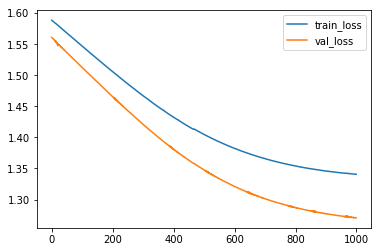

In [22]:
epochs = 1000

losses, val_losses = [], []
batch_size=50

train_iter = torch.utils.data.DataLoader(dataset=ds, batch_size=len(ds), shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=ds2, batch_size=len(ds2), shuffle=True)

for epoch in range(epochs):
    
    loss = 0
    tmp_losses = []
    for train_X, train_y in train_iter:
        
        loss = mycdf.loss(train_X)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        tmp_losses.append(loss.data.numpy())
        
        del loss
        loss = 0
        
    with torch.set_grad_enabled(False):
        tmp_val_losses = []
        for val_X, val_y in val_iter:
            val_loss = mycdf.loss(val_X)
            val_losses.append(val_loss.data.numpy())
            tmp_val_losses.append(val_loss.data.numpy())
            
    if epoch % 50 == 0:
        print('Epoch {}: loss{} val_loss{} '.format(epoch,np.mean(tmp_losses),np.mean(tmp_val_losses)))
        
import matplotlib.pyplot as plt
plt.plot(losses,label="train_loss")
plt.plot(np.arange(0, len(losses), int(len(losses)/len(val_losses))), val_losses, label="val_loss")
plt.legend()
plt.show()

In [24]:
from torch.autograd import Variable

def sample_preds(pi, sigma, mu, samples=1000):
    N, K = pi.shape
    _, KT = mu.shape
    T = int(KT / K)
    out = Variable(torch.zeros(N, samples, T))
    for i in range(N):
        for j in range(samples):
            u = np.random.uniform()
            prob_sum = 0
            for k in range(K):
                prob_sum += pi.data[i,k]
                if u < prob_sum:   # 直方图选择概率
                    # sample from the k-th component
                    for t in range(T):
                        sample = np.random.normal(mu.data[i,k*T+t], np.sqrt(sigma.data[i, k]))
                        out[i,j,t] = sample
                    break
    return out

In [25]:
pi1, mu1, sigma1 = F.softmax(mycdf.pi).view(1, -1), mycdf.mu.view(1, -1), torch.exp(mycdf.sigma).view(1, -1)

C:\Users\Reinhold\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [26]:
preds_x = sample_preds(pi1, sigma1, mu1)

In [27]:
pi2, mu2, sigma2 = mycdf.fx2x1(preds_x)

In [28]:
pi1.shape

torch.Size([1, 12])

In [29]:
preds_x2 = sample_preds(pi2, sigma2, mu2, samples=1)

In [32]:
preds_x2 = preds_x2.permute(1,0,2)

In [33]:
preds_x2.shape

torch.Size([1, 1000, 1])

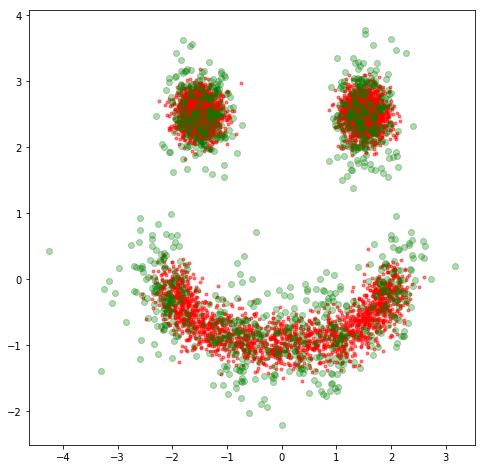

In [39]:
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'r.', alpha=0.5)
for i in range(preds_x2.shape[0]):
    plt.plot(preds_x.squeeze(1).detach().numpy()[i], preds_x2.squeeze(1).numpy()[i], 'go', alpha=0.3)
plt.show()